# Introduction

[[Kaplan et al, 2020]](https://arxiv.org/abs/2001.08361) observe that large language models (LLMs) based on the transformer architecture obey scaling laws over several orders of magnitude. For instance, the test loss $L$ reached by a model with $N$ parameters, when trained with a large enough dataset and enough compute, follows the relation
$$ (1) \qquad L \sim \left( \frac{N_c}{N} \right)^{\alpha_N}\,, 
\qquad \alpha_N \approx 0.076\,. $$
A natural question is then whether this behavior is specific to the model, the choice of dataset (language), or whether it also arises in a large class of models.

Such power laws are ubiquitous in critical systems, which suggests that the same behavior can be found in a large class of models.
As an example, here we consider a toy model which also exhibits the relation (1), with a different critical exponent $\alpha_N$. As our dataset, we consider the data $X,Y$ generated from the so-called Gaspard-Rice model [[Gaspard, Rice, 1989]](http://dx.doi.org/10.1063/1.456017). This model defines a function $f(X)$, and we obtain the data by sampling it at $N$. The relevant property of this model is that $f$ is a fractal of known (Hausdorff) dimension $D_0 \sim 0.61$ [[Yalcinkaya, Lai, 1995]](http://dx.doi.org/10.1063/1.168549). We then train a gaussian process on this dataset and calculate the test loss function $L(N)$ for $N$ the number of training points. We find experimentally $\alpha_N \sim 0.4$.

This result has a simple explanation. The Hausdorff dimension $D_0$ of a fractal is closely related to a quantity known as the uncertainty exponent $\alpha$ <a href="https://doi.org/10.1016/0375-9601(83)90945-3">[Grebogi et al, 1983]</a>. The coefficient $\alpha$ measures the fraction of points $f$ whose neighborhood is "uncertain", i.e. where the function varies rapidly (more precisely, these are the points at the boundary of a basin of attraction). As shown there, $f$ depends on the scale $l$ defining the neighborhood as
$$ f \sim l^\alpha \,.$$
This is particularly relevant to evaluate the loss function: points whose neighborhoods are "certain" are good predictors for the function in that neighborhood; conversely points with "uncertain" neighborhoods are bad predictors for the function. So the fraction $f$ is a good predictor of the loss function $L$. Furthermore, the relevant scale in the problem is the density of points $l \sim 1/N$, so that we expect
$$L \sim N^{-\alpha} \,. $$
Finally, we note that $\alpha$ was shown in <a href="https://doi.org/10.1016/0375-9601(83)90945-3">[Grebogi et al, 1983]</a> to be related to the Haussdorf dimension through
$$\alpha = 1 - D_0 \,.$$
This is in agreement with our result.

# The toy model

Start by importing some packages:

In [1]:
# Standard imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# Gaussian process regression using TensorFlow via GPFlow
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow

# Extra utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tqdm import tqdm  # for progress bars

np.random.seed(42)  # consistent results

/home/maxime/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-06-20 23:18:17.118245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 23:18:17.875845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Generating the data

In the following we use data generated by the Gaspard-Rice model, which is an example of a chaotic scattering process. The input values $X$ correspond to an impact parameter, and the output values $Y$ correspond to an angle (between 0 and $2\pi$). An implementation on Python as well as an introduction to the model can be found on my [GitHub page](https://github.com/maxtrepanier/gaspard-rice). Let's download the module and use it generate the data.

In [2]:
!wget https://raw.githubusercontent.com/maxtrepanier/gaspard-rice/main/scatter.py

--2024-06-20 23:18:22--  https://raw.githubusercontent.com/maxtrepanier/gaspard-rice/main/scatter.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5496 (5.4K) [text/plain]
Saving to: ‘scatter.py’

scatter.py          100%[===================>]   5.37K  --.-KB/s    in 0.001s  

2024-06-20 23:18:22 (9.72 MB/s) - ‘scatter.py’ saved [5496/5496]



In [3]:
import scatter
N_train = 5000  # generate sufficientely many points
N_test = 100
gr = scatter.GaspardRice()  # initialise the model
impact_params = np.linspace(0, 0.5, N_train + N_test)  # values for X
angle, transit = gr.scattering_range_angles(impact_params)  # generate data

X = impact_params[:,None] / 0.5
Y = angle[:,None]
Y -= np.pi  # center the data to zero
Y /= np.pi  # normalise the range
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=N_test, random_state=42)

Plot the result:

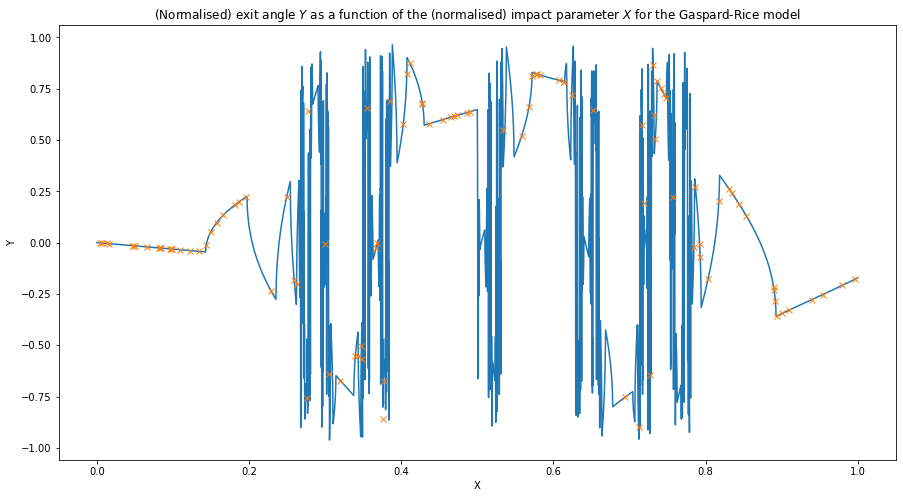

In [4]:
sort_index_train = np.argsort(X_train, axis=0)[:,0]  # sort here to draw points in order!
_, ax = plt.subplots(1, figsize=(15,8))
ax.plot(X_train[sort_index_train], Y_train[sort_index_train])
ax.plot(X_test, Y_test, 'x')
ax.set_title("(Normalised) exit angle $Y$ as a function of the (normalised) impact parameter $X$ for the Gaspard-Rice model")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

## Training the models

First, define some helper functions:

In [5]:
def train_model(model : gpflow.models.GPModel, print_summary : bool = False) -> None:
    """ Fits the gaussian process to its data by tuning the hyperparameters of its kernel.
    """
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    if print_summary:
        gpflow.utilities.print_summary(model, "notebook")

# Adapted from https://gpflow.github.io/GPflow/develop/notebooks/getting_started/large_data.html
def plot_model(model: gpflow.models.GPModel) -> matplotlib.axes._axes.Axes:
    X, Y = model.data
    Xplot = np.linspace(0.0, 1.0, 200)[:, None]

    y_mean, y_var = model.predict_y(Xplot, full_cov=False)
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
    ax.plot(X, Y, "kx", mew=2, label="train")
    (mean_line,) = ax.plot(Xplot, y_mean, "-", label="prediction")
    color = mean_line.get_color()
    ax.plot(Xplot, y_lower, lw=0.1, color=color)
    ax.plot(Xplot, y_upper, lw=0.1, color=color)
    ax.fill_between(
        Xplot[:, 0], y_lower[:, 0], y_upper[:, 0], color=color, alpha=0.1
    )

    # Also plot the inducing variables if possible:
    iv = getattr(model, "inducing_variable", None)
    if iv is not None:
        ax.scatter(iv.Z, np.zeros_like(iv.Z), marker="^")

    return ax

An example, gaussian process regression (GPR) on $N = 1000$ points.

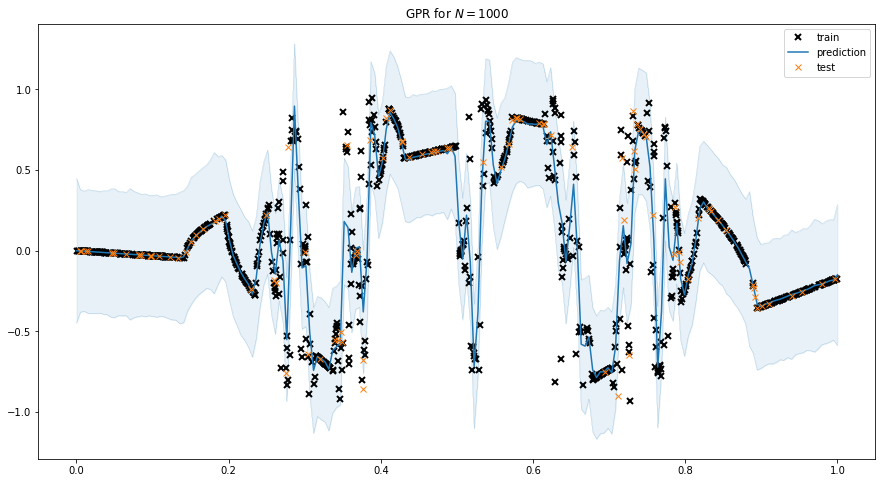

In [6]:
# select 1000 points to train the model
index = np.random.choice(np.arange(len(X_train)), 1000, replace=False)
model_test = gpflow.models.GPR((X_train[index], Y_train[index]),
                               kernel = gpflow.kernels.SquaredExponential(variance=1., lengthscales=0.1),
                               noise_variance=0.3
                              )
train_model(model_test)
ax = plot_model(model_test)
ax.plot(X_test, Y_test, 'x', label="test")
ax.set_title("GPR for $N=1000$")
plt.legend()
plt.show()

For reference, the test loss is:

In [7]:
Y_predict, _ = model_test.predict_f(X_test)
mean_squared_error(Y_test, Y_predict)

0.03423583100915945

Then we perform the following experiment. We train a gaussian process on $N$ data points, and vary $N$. We train $k$ copies of the model on a random subset of the training points to get a better estimate of the resulting test loss.

In [8]:
Ns = np.logspace(1, 3, 10).astype('int')  # trial values of N
k=7  # nb of experiments
test_loss = []  # holds resulting test loss
models = []  # holds a copy of trained models
for N in tqdm(Ns):
    # store results in a list
    test_loss.append([])
    models.append([])
    for _ in range(k):
        index = np.random.choice(np.arange(len(X_train)), N, replace=False)  # draw points from training set
        model = gpflow.models.GPR((X_train[index], Y_train[index]),
                                  kernel = gpflow.kernels.SquaredExponential(variance=1., lengthscales=0.1),
                                  noise_variance=0.3
                                 )
        train_model(model)
        models[-1].append(model)  # append model to last list
        Y_predict, _ = model.predict_f(X_test)
        test_loss[-1].append(mean_squared_error(Y_test, Y_predict))
test_loss = np.array(test_loss)

100%|███████████████████████████████████████████| 10/10 [01:06<00:00,  6.62s/it]


Sanity check, look at the predictions:

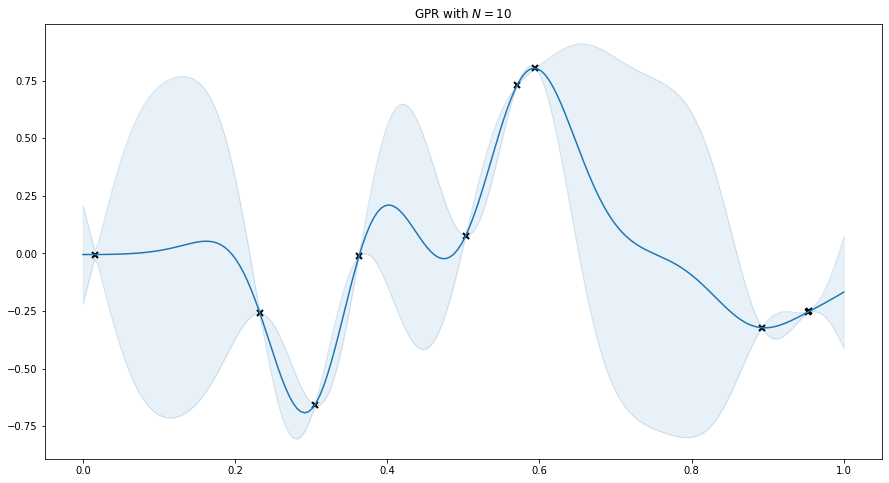

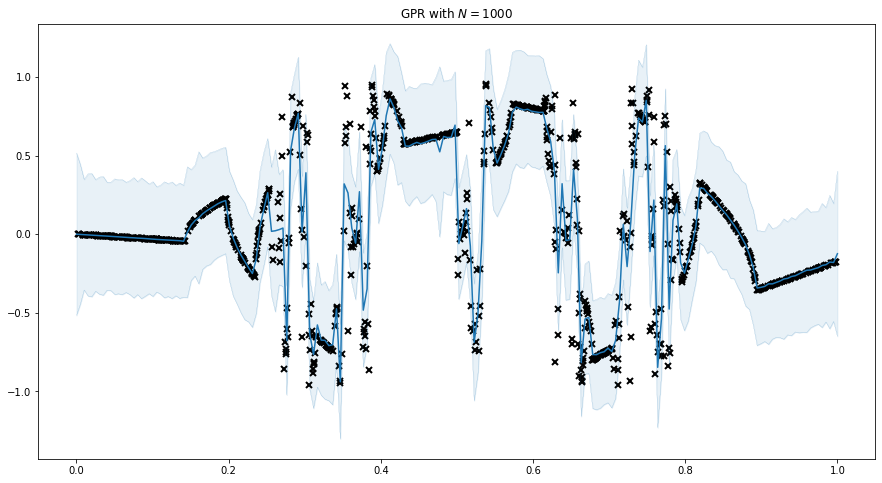

In [14]:
ax = plot_model(models[0][5])  # for 10 data points
ax.set_title("GPR with $N=10$")
plt.show()
ax = plot_model(models[-1][0])  # for 1000 data points
ax.set_title("GPR with $N=1000$")
plt.show()

Finally we obtain the loss function. We perform a fit to extract the critical exponent.

L = c * N^α, α = -0.408 ± 0.034


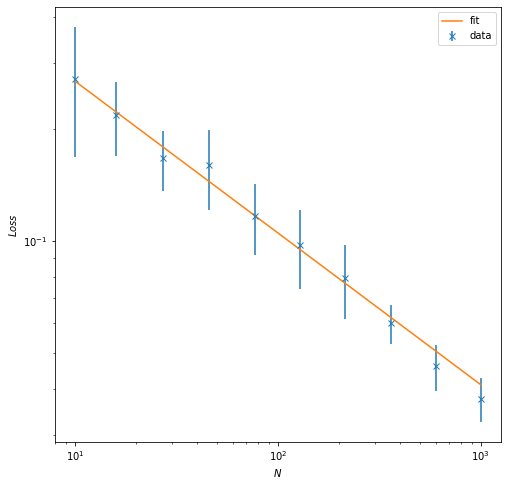

In [10]:
from scipy.optimize import curve_fit

def trial_fit(x, c0, alpha):
    return c0 * x ** alpha

Ns_extended = np.ravel(Ns[:,None] * np.ones(k))  # create k copies, flatten
test_loss_flat = np.ravel(test_loss)
fit_params, cov = curve_fit(trial_fit, Ns_extended, test_loss_flat, p0=(1,1))

avg_test_loss = np.average(test_loss, axis=1)
_, ax = plt.subplots(1, figsize=(8,8))
ax.errorbar(Ns, avg_test_loss, yerr=np.std(test_loss, axis=1), label="data", fmt='x')
ax.plot(Ns, trial_fit(Ns, *fit_params), label="fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("$N$")
ax.set_ylabel("$Loss$")
plt.legend()
print(f"L = c * N^α, α = {fit_params[1]:.3f} ± {cov[1][1]**0.5:.3f}")
plt.show()